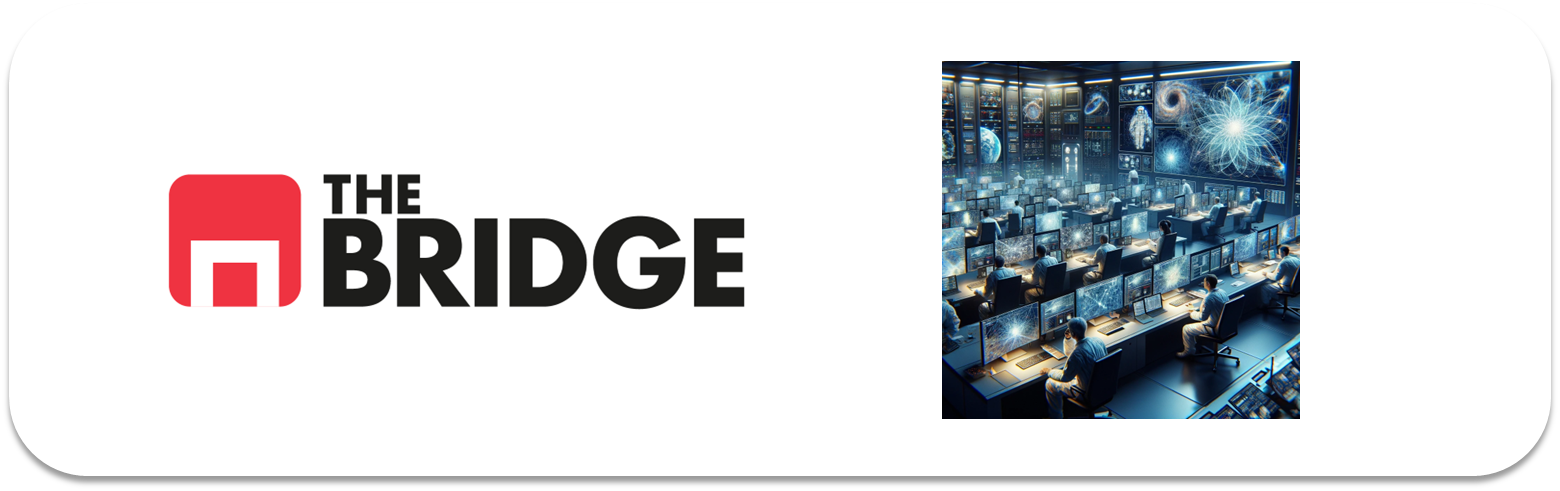

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning con CNN**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix

from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNetV2
from tensorflow.keras import Model

2025-07-17 21:01:46.063393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 21:01:46.204455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752778906.249952    8925 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752778906.263246    8925 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752778906.365381    8925 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



## 1. Datos

### Carga de datos

Primero recolectamos las imágenes, las redimensionamos y las asignamos a nuestro juego X,y.  
Para ello me valgo de la función creada en el workout.

In [ ]:
path_train = './data/seg_train'
path_test = './data/seg_test'

folders = os.listdir(path_train)

def read_data(directorio, reshape_dim=(64, 64)):        # dimensiono a 64 pixeles ya que a más resolución se caemi ordenador
    X, y = [], []                                       
    for folder in folders:
        path_folder = '/'.join([directorio, folder])
        for file in os.listdir(path_folder):
            image = imread('/'.join([path_folder, file]))
            image = cv2.resize(image, reshape_dim)

            X.append(image)
            y.append(folder)  

    return np.array(X),np.array(y)

In [ ]:
X_train, y_train = read_data(path_train)
X_test, y_test = read_data(path_test)

### Visualización

A continuación, visualizamos algunas imágenes aleatorias, para comprobar resolución y etiquetas.  
Igualmente, reutilizo una función del workout.

In [ ]:
def visualiza(num_images:int, n_col=5, set_image=X_train, set_labels=y_train):
    '''
    num_images: número de imágenes a mostrar \n
    n_col:      número de columnas a mostrar
    '''
    num_list = list(np.random.randint(0, set_image.shape[0], num_images))
    images = set_image[num_list]
    labels = set_labels[num_list]

    columns = n_col if len(images) > n_col else len(images)
    rows = len(images) // 5 if len(images)%5 == 0 else (len(images) // 5) +1
    fig, ax = plt.subplots(rows, columns, figsize=(columns*3, rows*2))
    ax = ax.flatten()
    for index, image in enumerate(images):
        ax[index].imshow(image, cmap='Greys')
        ax[index].axis('off')
        ax[index].set_title(labels[index])

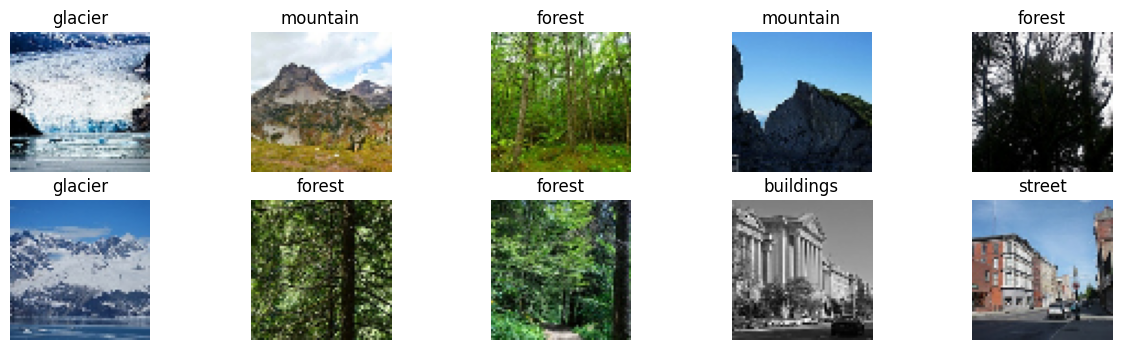

In [ ]:
visualiza(10)

Comprobamos dimensiones del dataset

In [ ]:
X_train.shape

(14034, 64, 64, 3)

Y por último, inspecciono la distribución de las categorías del target.  
En este caso, podemos decir que está bastante equilibrado entre 6 categorias. 

In [ ]:
pd.Series(y_train).value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

### Transformación

Antes de entrar en faena, terminamos de preparar los datos.  
Para ello, escalamos las X y codificamos las y.  
Por último, *barajamos* el dataset de entrenamiento. 

In [ ]:
# No podemos escalar como queramos, 
# ya que los modelos de keras requieren su propio escalado
# https://keras.io/api/applications/mobilenet/

'''
X_train = X_train / 255
X_test = X_test / 255
'''

In [ ]:
dic_clases = {value:index for index, value in enumerate(np.unique(y_train))}

y_train_num = pd.Series(y_train).map(dic_clases)
y_test_num = pd.Series(y_test).map(dic_clases)

In [ ]:
X_shuffle, y_shuffle = shuffle(X_train, y_train_num)

## 2. Transfer Learning

### Modelo

Para mi caso de estudio emplearé como modelo base *MobileNetV2*, ya que según el [cuadro comparativo](https://keras.io/api/applications/), ofrece una precisión un poco menor al resto (71,3 % para predicciones exactas), pero una precisión general similar (90 % para predicción entre las 5 categorías más probables), teniendo como puntos a favor el menor número de parámetros a entrenar (3.5M frente a los 23.9M de *InceptionV3*), con una profundidad similar a *ResNet50* y un tiempo por paso de predicción de casi la mitad la resto (25.9 ms/paso).  

En la descripción nos dicen que:

>[MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. It has a drastically lower parameter count than the original MobileNet. MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.

Por tanto, comprobemos cuanto de efectivo es.

In [ ]:
# Descargamos el modelo sin cabeza pero con los pesos entrenados
# El tamaño mínimo de imagen deberían de ser 96 píxeles, ya que está entrenado para esas dimensiones de imagen, pero con más resolución la memoria caché colapsa

base_model = MobileNetV2(input_shape=(64, 64, 3), weights='imagenet', include_top=False)

/tmp/ipykernel_142372/2159932511.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(64, 64, 3), weights='imagenet', include_top=False)
2025-07-17 13:58:33.183732: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
# Congelamos los pesos de las capas de convolución

for layer in base_model.layers:
    layer.trainable = False

Construimos modelo agregando las [capas de preprocessing de keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input)

In [ ]:
# Corrección agregando preprocessing del modelo keras

i = layers.Input([64, 64, 3], dtype="uint8")
x = ops.cast(i, "float32")
x = keras.applications.mobilenet.preprocess_input(x)
x = base_model(x)

x = layers.Flatten()(base_model.output)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(6, activation='softmax')(x)

model = Model(base_model.inputs,x)
model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

model.summary()

In [ ]:
# Creamos la red neuronal, juntamos todo y compilamos
'''
x = layers.Flatten()(base_model.output)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(6, activation='softmax')(x)

model = Model(base_model.inputs,x)
model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

model.summary()
'''

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 4,883,014 (18.63 MB)

 Trainable params: 2,625,030 (10.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entrenamiento

Para el entrenamiento estableceremos un *early stopping* para no realizar todas las épocas sino mejora el rendimiento, y un *model checkpoint* para no perder los progresos en caso de que el kernel o la CPU colapse. 

In [ ]:
early = EarlyStopping(patience= 5, restore_best_weights= True)
checkpoint = ModelCheckpoint(filepath='./model/checkpoint.model.keras',                 # fichero donde se guardará el modelo 
                            monitor='val_accuracy', mode='max', save_best_only=True)    # frecuencia con la que se guardará, en este caso, cada vez que 'val_accuracy' sea máximo
batch_size = 64                                                                         # cubiertas las espaldas, démosle un poco de más caña

from time import time
t_zero = time()
history = model.fit(X_shuffle, 
                    y_shuffle,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=30,                                                          # En los ejercicios de la unidad anterior llegados a este punto el pescado estaba vendido
                    callbacks=[early, checkpoint])                                      # Estableciendo los callbacks, podemos ejecutar todo directamente sin miedo al éxito
print((time() - t_zero)/ 60)                                                            # minutos de ejecución

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - acc: 0.6970 - loss: 1.0588

/home/vencejo/TheBridge/ONLINE_DS_THEBRIDGE_Ejercicios/05_Deep_Learning/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


176/176 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - acc: 0.6973 - loss: 1.0571 - val_acc: 0.8019 - val_loss: 0.5568
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 25s 143ms/step - acc: 0.8289 - loss: 0.4669 - val_acc: 0.8204 - val_loss: 0.5246
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - acc: 0.8601 - loss: 0.3773 - val_acc: 0.8176 - val_loss: 0.5380
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 25s 142ms/step - acc: 0.8728 - loss: 0.3305 - val_acc: 0.8258 - val_loss: 0.5331
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - acc: 0.8925 - loss: 0.2794 - val_acc: 0.8261 - val_loss: 0.5373
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - acc: 0.9125 - loss: 0.2463 - val_acc: 0.8269 - val_loss: 0.5533
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - acc: 0.9291 - loss: 0.1952 - val_acc: 0.8233 - val_loss: 0.5824
2.715052763621012


Veamos la evolución del entrenamiento

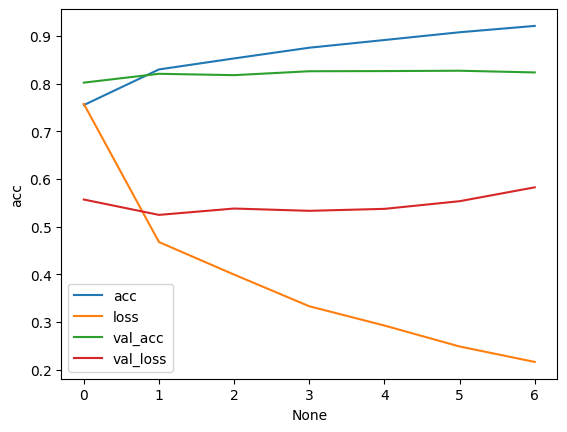

In [ ]:
hist_df = pd.DataFrame(history.history)

for feature in hist_df.columns:
    sns.lineplot(hist_df, x=hist_df.index, y=feature, label=feature);

*Parece que ha comenzado a hacer overfitting muy pronto, desde la primera época, aunque los valores en general no están nada mal, teniendo en cuenta la resolución de las imágenes*

## Evaluación

Ahora veremos lo bueno que es el modelo, evaluando contra test, contrastado lasmétricas en un classification report y los resultados en una matriz de confusión

In [ ]:
# Primero evaluamos contra test, en este caso, ya no hace falta que los datos estén desordenados

model.evaluate(X_test, y_test_num)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.8389 - loss: 0.4480


[0.5284836292266846, 0.7984085083007812]

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.69      0.73      0.71       349
           3       0.80      0.72      0.76       525
           4       0.82      0.82      0.82       510
           5       0.96      0.91      0.93       501

    accuracy                           0.80      1885
   macro avg       0.54      0.53      0.54      1885
weighted avg       0.83      0.80      0.81      1885



/home/vencejo/TheBridge/ONLINE_DS_THEBRIDGE_Ejercicios/05_Deep_Learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vencejo/TheBridge/ONLINE_DS_THEBRIDGE_Ejercicios/05_Deep_Learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vencejo/TheBridge/ONLINE_DS_THEBRIDGE_Ejercicios/05_Deep_Learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true sa

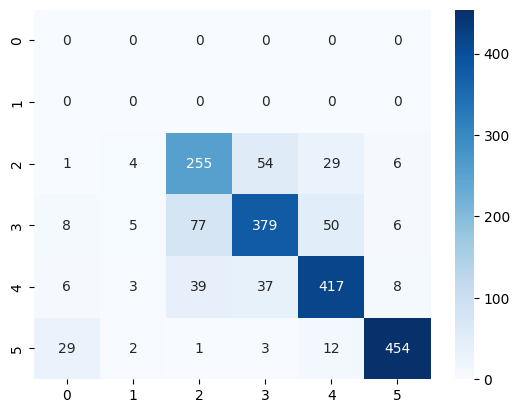

In [ ]:
# Imprimimos infome de clasificación para contrastar métricas y ver qué categorías le cuesta más identificar
# Además imprimiré una matriz de confusión para valorar directamente los resultados

y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

print(classification_report(y_test_num, y_pred))

sns.heatmap(confusion_matrix(y_test_num, y_pred), annot=True, fmt='.4g', cmap='Blues');

In [ ]:
for index,value in dic_clases.items():
    print(value, index)

0 buildings
1 forest
2 glacier
3 mountain
4 sea
5 street


*Vaya, parece que tuve un problema con la carga de datos, ya que no aparecen imágenes clasificadas como 'buildings' o 'forest'.*  
*No obstante, el modelo no tiene mala pinta, clasificando muy bien las calles (métricas por encima de 0.9), y bastante bien el mar y las montañanas, con un rendimiento en torno al 80%. Sí tiene problemas al identificar los glaciares, que además es la clase minoritaria*

## 3. Fine Tunning

Ahora repetiremos los pasos anteriores de modelado, entrnamiento y evaluación pero sin coger los pesos del modelo, los cuáles entrenaremos en base a nuestro dataset de train.

### Modelo


In [31]:
# Descargamos el modelo sin cabeza pero con los pesos entrenados
# El tamaño mínimo de imagen deberían de ser 96 píxeles, ya que está entrenado para esas dimensiones de imagen, pero con más resolución la memoria caché colapsa
# Marcamos como ninguno los pesos

base_model = MobileNetV2(input_shape=(64, 64, 3), weights=None, include_top=False)

In [32]:
# Creamos la red neuronal, juntamos todo y compilamos

x = layers.Flatten()(base_model.output)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(6, activation='softmax')(x)

model = Model(base_model.inputs,x)
model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 4,883,014 (18.63 MB)

 Trainable params: 4,848,902 (18.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Entrenamiento

In [33]:
early = EarlyStopping(patience= 5, restore_best_weights= True)
checkpoint = ModelCheckpoint(filepath='./model/checkpoint.model.keras',                 # fichero donde se guardará el modelo 
                            monitor='val_accuracy', mode='max', save_best_only=True)    # frecuencia con la que se guardará, en este caso, cada vez que 'val_accuracy' sea máximo
batch_size = 64                                                                         # cubiertas las espaldas, démosle un poco de más caña

from time import time
t_zero = time()
history = model.fit(X_shuffle, 
                    y_shuffle,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=30,                                                          # En los ejercicios de la unidad anterior llegados a este punto el pescado estaba vendido
                    callbacks=[early, checkpoint])                                      # Estableciendo los callbacks, podemos ejecutar todo directamente sin miedo al éxito
print((time() - t_zero)/ 60)     

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - acc: 0.2911 - loss: 2.1227

/home/vencejo/TheBridge/ONLINE_DS_THEBRIDGE_Ejercicios/05_Deep_Learning/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_accuracy available.
  if self._should_save_model(epoch, batch, logs, filepath):


176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 483ms/step - acc: 0.2915 - loss: 2.1199 - val_acc: 0.1785 - val_loss: 1.7940
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 475ms/step - acc: 0.5297 - loss: 1.1678 - val_acc: 0.1589 - val_loss: 1.8014
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 478ms/step - acc: 0.6259 - loss: 0.9842 - val_acc: 0.1589 - val_loss: 1.8304
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 483ms/step - acc: 0.6578 - loss: 0.9528 - val_acc: 0.1589 - val_loss: 1.8267
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 479ms/step - acc: 0.6918 - loss: 0.8529 - val_acc: 0.1589 - val_loss: 1.8684
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 477ms/step - acc: 0.7259 - loss: 0.7763 - val_acc: 0.1589 - val_loss: 1.8605
8.700394070148468


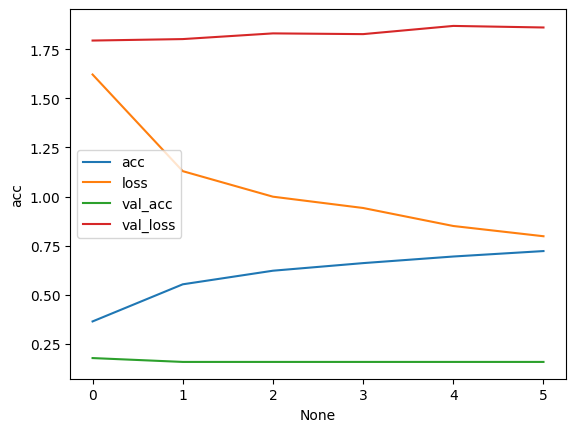

In [34]:
# Y vemosla evolución

hist_df = pd.DataFrame(history.history)

for feature in hist_df.columns:
    sns.lineplot(hist_df, x=hist_df.index, y=feature, label=feature);

*Vaya, un resultado muy pobre: sólo train ya tiene peorprecisión que el modeo anterior, y aquí en la validez ni siquiera lega al 20 %*

### Evaluación

In [35]:
model.evaluate(X_test, y_test_num)

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - acc: 0.2602 - loss: 1.8120


[1.7793899774551392, 0.2785145938396454]

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step
              precision    recall  f1-score   support

           2       0.00      0.00      0.00       349
           3       0.28      1.00      0.44       525
           4       0.00      0.00      0.00       510
           5       0.00      0.00      0.00       501

    accuracy                           0.28      1885
   macro avg       0.07      0.25      0.11      1885
weighted avg       0.08      0.28      0.12      1885



/home/vencejo/TheBridge/ONLINE_DS_THEBRIDGE_Ejercicios/05_Deep_Learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vencejo/TheBridge/ONLINE_DS_THEBRIDGE_Ejercicios/05_Deep_Learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/vencejo/TheBridge/ONLINE_DS_THEBRIDGE_Ejercicios/05_Deep_Learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in lab

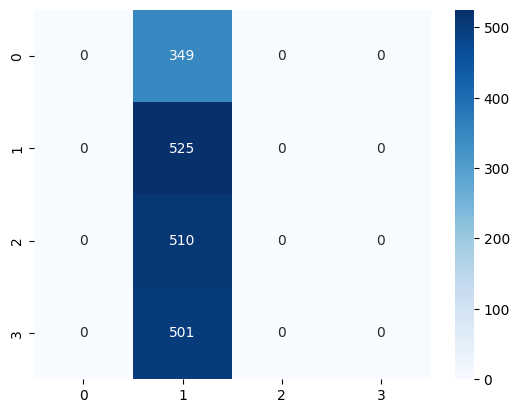

In [36]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

print(classification_report(y_test_num, y_pred))

sns.heatmap(confusion_matrix(y_test_num, y_pred), annot=True, fmt='.4g', cmap='Blues');

*Y aquí vemos por qué tiene tan mala precisión: clasifica cada en la misma categoría, la 1 que corresponde a bosque*